# 1 - Understanding the problem: 
```
Developed by Rodrigo Ramos & Victor Bocanegra
```

The purpose of this code is to create and train a Neural Network model that can predict categories for forest images and test to know to which class of deforested area they belong to. 

We're provided with a train and a test dataset (in csv format) that contain information about the images.

The images themselves are contained in a zip file. We will first load the images and we'll convert them to a tensor using numpy. We'll then visualize them using matplotlib. We will then create arrays for the features and labels. Using normalization and one-hot encoding techniques, we'll prepare the data which we'll later feed to our NN model, which we'll create using Tensorflow.

Finally, we'll evaluate our model (Using the F1 Score) and we'll produce a file containing our predictions for the test data.

# 2.- Importing libraries

In [1]:
# Since we're working with Google Colab, we need to import this library to bring the data from our drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!pip install tensorflow
!pip install jupyterthemes 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 20.8 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 1.6 MB 56.7 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 


In [3]:
from jupyterthemes import jtplot
jtplot.style (theme = 'monokai', context = 'notebook', ticks = True, grid = False)
# Setting the style of the notebook to be monokai theme.
# This line is important to ensure that we are able to see the x and y axes clearly


In [4]:
import numpy as np # We'll use numpy to work with matrices
import tensorflow as tf # We'll use tensorflow to create our model
tf.config.experimental_run_functions_eagerly(True) 

from tensorflow import keras # 
import pandas as pd # We'll use pandas to create our final dataframe and export it to a json file
import matplotlib.pyplot as plt # Used for visualization
import seaborn as sns # Used for our confusion matrix
import random
from keras.utils.np_utils import to_categorical # Used to convert to one -hot encoding
import zipfile # Used to unzip our data
import io

import os # Used to go through files in our system

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [5]:
#we're unziping the directory from google drive to our jupyter notebook
!unzip ./gdrive/MyDrive/NUWE_HACK/train_test_data.zip

Archive:  ./gdrive/MyDrive/NUWE_HACK/train_test_data.zip
   creating: train_test_data/test/
  inflating: train_test_data/test/1.png  
  inflating: train_test_data/test/1000.png  
  inflating: train_test_data/test/1001.png  
  inflating: train_test_data/test/1002.png  
  inflating: train_test_data/test/1004.png  
  inflating: train_test_data/test/1005.png  
  inflating: train_test_data/test/1006.png  
  inflating: train_test_data/test/1007.png  
  inflating: train_test_data/test/101.png  
  inflating: train_test_data/test/1012.png  
  inflating: train_test_data/test/1013.png  
  inflating: train_test_data/test/1024.png  
  inflating: train_test_data/test/1025.png  
  inflating: train_test_data/test/1026.png  
  inflating: train_test_data/test/1028.png  
  inflating: train_test_data/test/103.png  
  inflating: train_test_data/test/1034.png  
  inflating: train_test_data/test/1036.png  
  inflating: train_test_data/test/1047.png  
  inflating: train_test_data/test/1048.png  
  inflating: 

In [6]:
#label dictionary for print the image with the accurate label
labels = {
    '0': 'Plantation',
    '1': 'Grassland/Shrubland',
    '2': 'Smallholder Agriculture'
}

In [7]:
# Creating a dataframe with the images label and path
data_training = pd.read_csv('./gdrive/MyDrive/NUWE_HACK/train.csv')
data_training.sort_values(by=['label'],inplace=True)

# Creating a dataframe with the images label and path
data_test = pd.read_csv('./gdrive/MyDrive/NUWE_HACK/test.csv')

In [8]:
#verifying image proportion inside data frame******************
counts = data_training.value_counts('label')
data_training.head(), sum(counts)

(      label  latitude   longitude  year                    example_path
 0         0 -2.051853  111.826093  2001  train_test_data/train/1297.png
 605       0 -1.391842  122.394483  2010   train_test_data/train/376.png
 606       0 -1.843256  114.969651  2002  train_test_data/train/1337.png
 1282      0  2.030024  101.167998  2007  train_test_data/train/1081.png
 1281      0  1.040827  100.629633  2008  train_test_data/train/1643.png, 1714)

In [9]:
#creating a list made of image matrix
from skimage import io
from skimage.transform import resize
IMGSIZE = 32
def create_data(data_set):
  """
  function that creates image data set
  """
  data_list = []

  for image in data_set['example_path']:
    path = os.path.join('./',image) # image path
    try: 
      img_array = io.imread(path) # Converting images to grayscale data
      #resizing image from 332*332 pixels to 32*32
      image_resized = resize(img_array, (IMGSIZE, IMGSIZE),
                       anti_aliasing=True)
      data_list.append(image_resized)
    except Exception as e:
      pass
    
  return data_list

In [10]:
# creating training data
training_data = create_data(data_training)
print(training_data)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1714


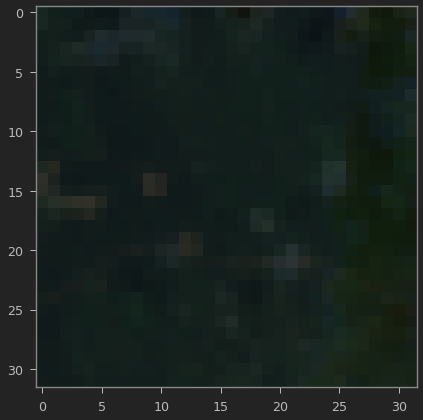

In [11]:
print(len(training_data))
plt.imshow(training_data[0])


In [12]:
#creating an array of targets
y = data_training['label']


# 3.- Visualizing the Data

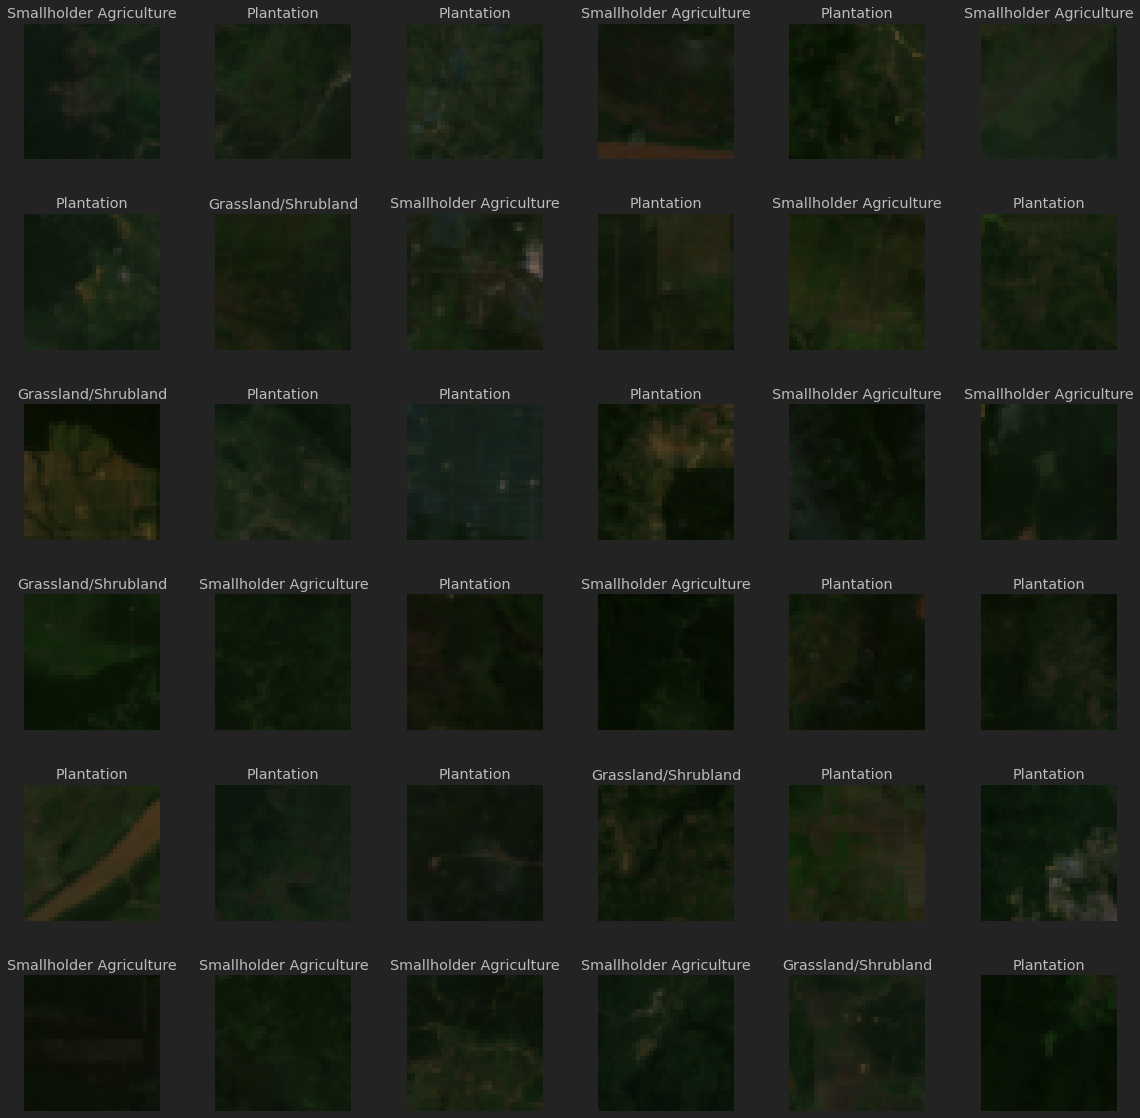

In [13]:
# Create a 6x6 grid with subplots
w_grid = 6
l_grid = 6

fig, axes = plt.subplots(l_grid, w_grid, figsize = (20, 20)) # In one figure, generate multiple plots
axes = axes.ravel()

n_training = len(training_data)

# A for loop that goes from 0 up until the lenght * width of the grid
for i in np.arange(0, l_grid * w_grid):
  index = np.random.randint(0, n_training) # Random number
  axes[i].imshow(training_data[index])
  axes[i].set_title(labels[str(y[index])]) # Shows the label
  axes[i].axis('off')

plt.subplots_adjust(hspace = 0.4)

(<BarContainer object of 3 artists>, {0: 860, 2: 658, 1: 196})

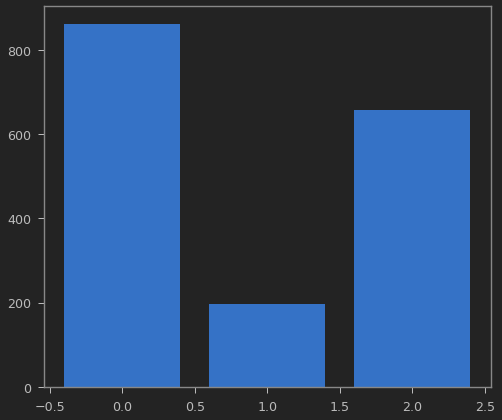

In [14]:
#visualizing the amount of data from our labels
#we realized that data is unbalanced
counts = dict(counts)
plt.bar(counts.keys(),counts.values()), counts

In [15]:
# An array of images with less samples (category # 1)
dataset_to_augment_1 = np.array([x for x in training_data[860:1056]])



In [16]:
# An array of images with less samples (category # 2)
dataset_to_augment_2 = np.array([x for x in training_data[1056:1714]])

In [17]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'reflect') # Adds pixels if needed when zooming or shifting

# With the images that have label 1 and that are unbalanced,
# we've created another 600 images to balance the samples
i = 0
!mkdir augmented
for batch in datagen.flow(dataset_to_augment_1, batch_size = 1,
                          save_to_dir = 'augmented',
                          save_prefix = 'aug',
                          save_format = 'png'):
  i += 1
  if i > 663:
    break


In [18]:
#  Augmented function 
def create_aug_data(training_data):

  for image in os.listdir('./augmented'):
    path2 = os.path.join('./augmented/',image) # image path
    try: 
      img_array = io.imread(path2) # Converting images to grayscale data
      #resizing image from 332*332 pixels to 32*32
      image_resized = resize(img_array, (IMGSIZE, IMGSIZE),
                      anti_aliasing=True)
      training_data.append(image_resized)
    except Exception as e:
      pass



In [19]:
# Overwritting our training data with new label 1 images
print(len(training_data))
create_aug_data(training_data)
print(len(training_data))



1714
2378


In [20]:
# Overwritting our y data
y = np.array(y)
print(len(y))
y = np.append(y, np.ones(664))

print(len(y))

1714
2378


In [21]:
np.count_nonzero(y == 0)

860

<BarContainer object of 3 artists>

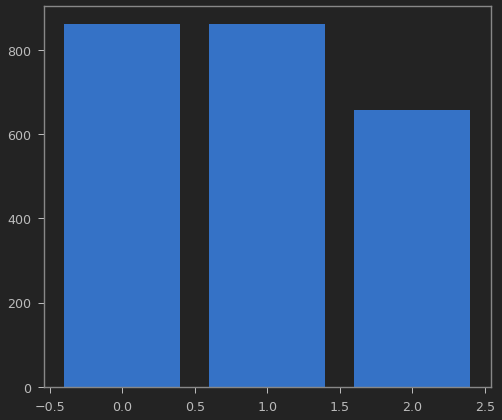

In [22]:
# Balanced data
new_count = {0:np.count_nonzero(y == 0), 
                 1:np.count_nonzero(y == 1), 
                 2:np.count_nonzero(y == 2),
                 }

plt.bar(new_count.keys(), new_count.values())


# 4.- Preparing the data

In [23]:
#normalize training data
#pixels came from 0 to 255 and they're changing to 0 to 1
x_norm = tf.keras.utils.normalize(training_data)
x_norm[0]

array([[[0.42211706, 0.67993499, 0.59958786],
        [0.38087164, 0.69826467, 0.60610498],
        [0.38719228, 0.69896427, 0.60127455],
        ...,
        [0.49413751, 0.77551308, 0.39294731],
        [0.52777367, 0.72696696, 0.43928805],
        [0.53179235, 0.68591619, 0.49670502]],

       [[0.43358394, 0.67339332, 0.59878744],
        [0.40198701, 0.69818796, 0.59240191],
        [0.41027135, 0.69098333, 0.59516338],
        ...,
        [0.51098788, 0.77992887, 0.36138946],
        [0.50645166, 0.74865859, 0.42780491],
        [0.514141  , 0.68552133, 0.51547991]],

       [[0.39751626, 0.69513445, 0.59897322],
        [0.40442948, 0.69369965, 0.59600133],
        [0.38086069, 0.69451066, 0.61040976],
        ...,
        [0.47721942, 0.78600846, 0.39300423],
        [0.45949708, 0.72777052, 0.50912916],
        [0.43697203, 0.66139223, 0.60960295]],

       ...,

       [[0.39258632, 0.66248942, 0.63795278],
        [0.39258632, 0.66248942, 0.63795278],
        [0.40831311, 0

In [24]:
# Saving the data structures
import pickle
pickle_out = open('X.pickle', 'wb')
pickle.dump(x_norm, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()



In [25]:
# # If we wanted to load the model
# pickle_in = open('X.pickle', 'rb')
# X = pickle.load(pickle_in)
# pickle_in = open('y.pickle', 'rb')
# y = pickle.load(pickle_in)

In [26]:
# spliting into validation and training data
# Getting our training and test data from x_norm and y_one_hot
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, train_size = 0.9, test_size = 0.1, shuffle=True,random_state=1)


In [27]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((2140, 32, 32, 3), (238, 32, 32, 3), (2140,), (238,))

In [28]:
#one hot encoding: changing categorical data to numerical one for train data set
y_one_hot_train = to_categorical(y_train)
y_one_hot_train[0]

#one hot encoding: changing categorical data to numerical one for test data set
y_one_hot_test = to_categorical(y_test)
y_one_hot_test[0]

array([1., 0., 0.], dtype=float32)

# 5.- Creating the model

In [29]:
# Our convolutional network model
cnn = tf.keras.Sequential()

# First layer with 3*3 kernel
# Regularization technique to improve generalization (dropouts and regularizers)
cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (32, 32, 3)))

cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(2,2)) # Reducing the size 
cnn.add(tf.keras.layers.Dropout(0.3)) 

# A second layer
cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu')) 

cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu')) 
cnn.add(tf.keras.layers.MaxPooling2D(2,2))
cnn.add(tf.keras.layers.Dropout(0.3))

# Flattening
cnn.add(tf.keras.layers.Flatten())

# Building the front forward NN

cnn.add(tf.keras.layers.Dense(1024, activation = 'relu'))
cnn.add(tf.keras.layers.Dropout(0.3))

# Adding two hidden layers
cnn.add(tf.keras.layers.Dense(1024, activation = 'relu'))

cnn.add(tf.keras.layers.Dense(3, activation = 'softmax')) # The output layer
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                        

In [30]:
# Compiling the model, we'll use the RMS optimizer and we'll optimize for loss
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay = 1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 6.- Training the model

In [31]:
# Defining the epochs and batch size
epochs = 100
batch_size =  64

In [32]:
# training our model
history = cnn.fit(
    x_train,
    y_one_hot_train,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


34/34 [==============================] - 8s 30ms/step - loss: 1.0300 - accuracy: 0.4841
Epoch 2/100
34/34 [==============================] - 1s 24ms/step - loss: 0.9580 - accuracy: 0.5678
Epoch 3/100
34/34 [==============================] - 1s 26ms/step - loss: 0.9545 - accuracy: 0.5607
Epoch 4/100
34/34 [==============================] - 1s 25ms/step - loss: 0.9299 - accuracy: 0.5818
Epoch 5/100
34/34 [==============================] - 1s 26ms/step - loss: 0.9300 - accuracy: 0.5804
Epoch 6/100
34/34 [==============================] - 1s 26ms/step - loss: 0.9057 - accuracy: 0.5846
Epoch 7/100
34/34 [==============================] - 1s 25ms/step - loss: 0.8862 - accuracy: 0.5981
Epoch 8/100
34/34 [==============================] - 1s 24ms/step - loss: 0.8806 - accuracy: 0.5972
Epoch 9/100
34/34 [==============================] - 1s 25ms/step - loss: 0.8715 - accuracy: 0.5958
Epoch 10/100
34/34 [==============================] - 1s 25ms/step - loss: 0.8606 - accuracy: 0.6028
Epoch 11/10

# 7.- Evaluating and predicting 

In [33]:
#determine the loss and accuracy values **** Test?
loss, accuracy = cnn.evaluate(x_test, y_one_hot_test)
print(f'loss: {loss * 100}, accuracy: {accuracy * 100}') 

8/8 [==============================] - 0s 27ms/step - loss: 2.0089 - accuracy: 0.5546
loss: 200.8880376815796, accuracy: 55.46218752861023


In [34]:
# Predicting classes
predicted_classes = cnn.predict(x_test)
predicted_classes
# Grab the predicted classes and show
predicted_classes = predicted_classes.argmax(1)
predicted_classes

y_test_max = y_one_hot_test.argmax(1)
y_test_max

8/8 [==============================] - 0s 7ms/step


array([0, 0, 2, 0, 0, 1, 0, 2, 1, 2, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 1, 0,
       1, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 0, 2, 2, 2,
       2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0,
       1, 0, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 2, 0, 0, 2, 1, 2,
       2, 1, 0, 1, 0, 1, 2, 1, 0, 2, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0, 0,
       1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 0, 0, 2, 2, 2, 1, 0, 0, 1, 1,
       2, 2, 2, 0, 0, 1, 0, 1, 0, 2, 1, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 2, 2, 2, 1, 2, 0, 2, 1, 2, 1, 0, 0, 0, 1,
       1, 2, 0, 1, 0, 1, 2, 1, 0, 1, 2, 0, 2, 1, 2, 2, 0, 2, 1, 0, 0, 0,
       0, 1, 0, 1, 2, 1, 2, 0, 0, 1, 0, 1, 2, 0, 2, 0, 1, 1, 2, 2, 0, 0,
       2, 0, 2, 2, 0, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 1, 2, 1])

In [35]:
# Obtenemos un reporte de clasificaciones
from sklearn.metrics import classification_report
print(classification_report(y_test_max, predicted_classes))
# Concluimos que el sistema es pobre para clasificar los ítems de las clases

              precision    recall  f1-score   support

           0       0.55      0.61      0.58        88
           1       0.67      0.65      0.66        72
           2       0.45      0.40      0.42        78

    accuracy                           0.55       238
   macro avg       0.56      0.55      0.55       238
weighted avg       0.55      0.55      0.55       238



In [36]:
# Ground truth values
#y_test_max = y_test.argmax()
#y_test_max

# Generate confusion matrix
#from sklearn.metrics import confusion_matrix 
#import seaborn as sns # Library for data visualization

#cm = confusion_matrix(y_test_max, predicted_classes)

#plt.figure(figsize = (10, 10))
#sns.heatmap(cm, annot = True)

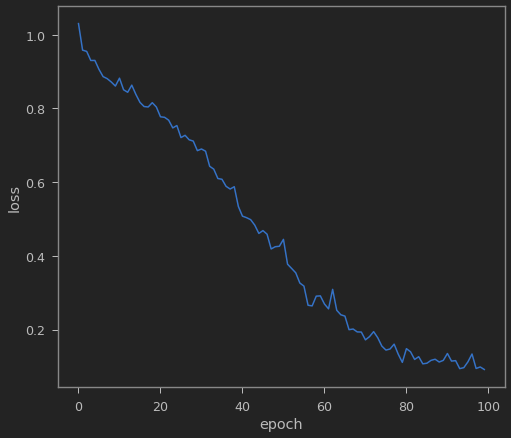

In [37]:
#visualizing the loss function
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

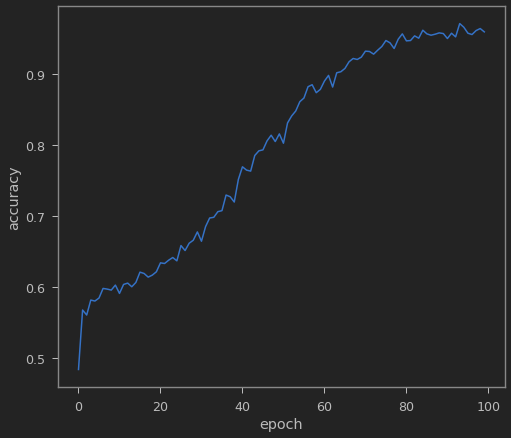

In [38]:
#visualizing the accuracy function
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

# 8.- Predicting Test Data

(32, 32, 3)


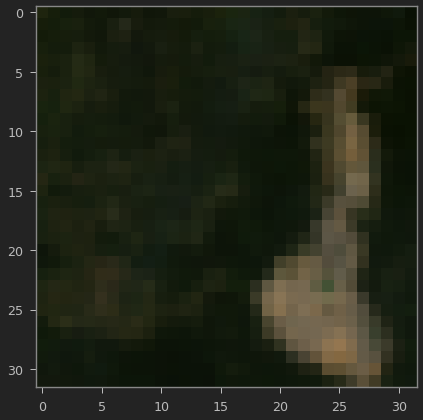

In [39]:
# Creating training data 
testing_data = create_data(data_test)

print(testing_data[-1].shape)

plt.imshow(testing_data[-1])


In [40]:
# normalize data
x_test = tf.keras.utils.normalize(testing_data)
x_test[0]

array([[[0.5286141 , 0.83387013, 0.15883241],
        [0.53921753, 0.82729265, 0.15757955],
        [0.59734294, 0.77486766, 0.20678856],
        ...,
        [0.42464472, 0.8846765 , 0.19241714],
        [0.49442336, 0.83035327, 0.25701944],
        [0.61636664, 0.71901752, 0.32110118]],

       [[0.51188205, 0.83937801, 0.18281502],
        [0.57227645, 0.79187579, 0.21314879],
        [0.62750429, 0.75536566, 0.18884142],
        ...,
        [0.42258553, 0.88134944, 0.21129276],
        [0.43547048, 0.86910851, 0.23455459],
        [0.52504762, 0.80207467, 0.28460714]],

       [[0.4858658 , 0.85026515, 0.20244408],
        [0.50306617, 0.83844362, 0.2096109 ],
        [0.51588926, 0.83335958, 0.19841895],
        ...,
        [0.44976469, 0.86493209, 0.22272001],
        [0.43513103, 0.86934681, 0.23430132],
        [0.48200213, 0.83818753, 0.2551776 ]],

       ...,

       [[0.48056933, 0.8650248 , 0.1441708 ],
        [0.45885721, 0.86945129, 0.18304238],
        [0.45786855, 0

In [41]:
# Predicting classes
predicted_classes = cnn.predict(x_test)
predicted_classes


16/20 [=======================>......] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


20/20 [==============================] - 0s 11ms/step


array([[7.4354583e-01, 2.7570937e-02, 2.2888334e-01],
       [8.9704513e-04, 7.0228386e-01, 2.9681906e-01],
       [3.3124539e-03, 2.3868436e-04, 9.9644887e-01],
       ...,
       [6.7225015e-01, 5.4150354e-02, 2.7359942e-01],
       [1.0000000e+00, 1.3311470e-08, 4.4044177e-09],
       [9.9761462e-01, 2.5708910e-06, 2.3827977e-03]], dtype=float32)

In [42]:
# Grab the predicted classes and show
predicted_classes = predicted_classes.argmax(1)
predicted_classes

array([0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 2, 0, 1, 0, 0, 2, 2, 1, 1, 1, 0, 0,
       2, 0, 1, 2, 1, 0, 1, 0, 0, 0, 2, 2, 1, 2, 0, 0, 0, 2, 1, 2, 2, 0,
       2, 2, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 0, 0, 0, 1,
       1, 0, 2, 1, 2, 0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 1,
       2, 2, 2, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 2, 1, 1, 2, 0, 0, 0,
       1, 0, 2, 1, 2, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 2, 2, 0, 0, 1, 0,
       0, 2, 0, 1, 1, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 1,
       0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2,
       1, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0,
       2, 1, 0, 0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1,
       1, 0, 2, 2, 1, 0, 1, 1, 1, 0, 2, 2, 0, 2, 0,

In [43]:
import re
import json

In [44]:
#filtering img number
img_number = [x.split("/")[-1].split(".")[0] for x in data_test['example_path'] if re.search("\d",x)]
# tuples_list = list(zip(img_number, predicted_classes))
prediction_df = pd.DataFrame(predicted_classes,img_number,columns=["target"])
predicted_json = prediction_df.to_json(path_or_buf='./predictions.json')
predicted_json